# missing values

Загрузка данных и анализ отсутствующих записей

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/blockchain/cleaned_wallet_data.csv")

# missing values per column
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100

print("Missing values count per column:\n", missing_counts)
print("\nPercentage of missing values per column:\n", missing_percent)


Missing values count per column:
 Transaction Hash           4040
Status                     4040
Method                     4040
Blockno                    4040
DateTime (UTC)             4040
From                          0
From_Nametag            5089263
To                        16316
To_Nametag              2388603
Amount                     4040
Value (USD)                4040
Txn Fee                    4040
total_tx                6137875
avg_value_usd           6137875
total_volume_usd        6137875
avg_gas                 6141695
unique_to               6141695
interacted_with_scam    6137875
recency_days            6141695
gas_ratio               6141695
risk_score              6137875
high_gas_user           6138095
dtype: int64

Percentage of missing values per column:
 Transaction Hash         0.065778
Status                   0.065778
Method                   0.065778
Blockno                  0.065778
DateTime (UTC)           0.065778
From                     0.000000
Fr

# Analyze patterns

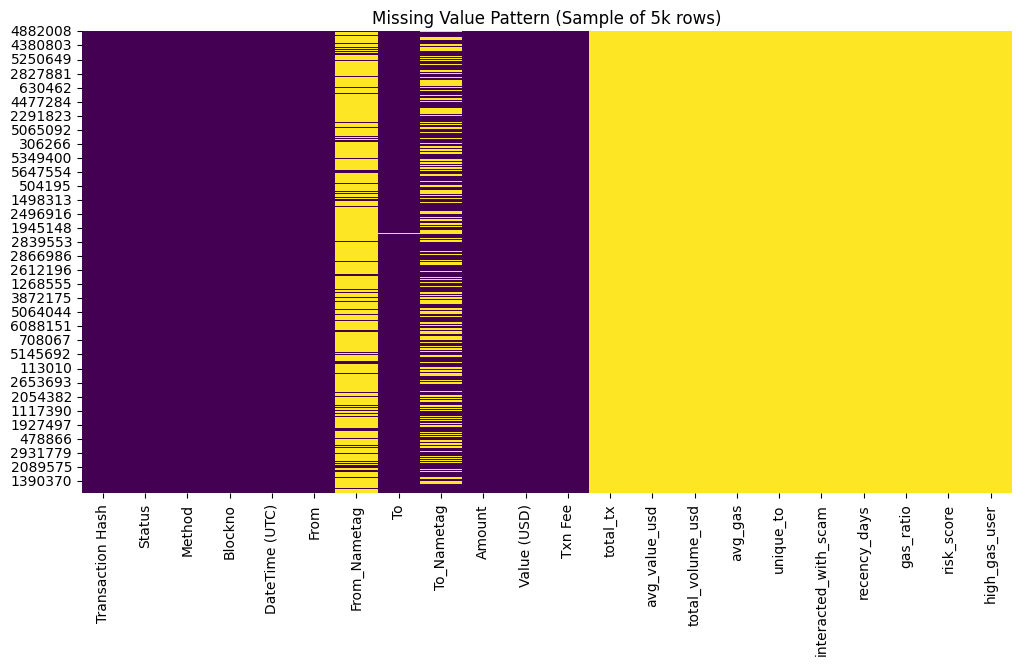

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sample_df = df.sample(n=5000, random_state=42)  # sample 5k rows
plt.figure(figsize=(12,6))
sns.heatmap(sample_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Value Pattern (Sample of 5k rows)")
plt.show()


# Возможные причины

Как правило, большинство кошельков с очень небольшим количеством транзакций могут не сообщать о сборах за транзакции, т.е. пропущенные сборы являются систематическими.

Во вновь созданных кошельках могут отсутствовать исторические данные, а также значения, сгруппированные по дате.

# Обнаружение выбросов/ аномалий

In [ ]:
# Basic outlier detection using z-score
from scipy import stats
import numpy as np

numeric_cols = ['Value (USD)', 'Txn Fee']
z_scores = np.abs(stats.zscore(df[numeric_cols].dropna()))
outliers = (z_scores > 3).any(axis=1)
print(f"Detected {outliers.sum()} extreme transactions")


Detected 30690 extreme transactions


# Выбор подходящего оружия

In [ ]:
#  numeric columns with median
df_filled_median = df.copy()
for col in numeric_cols:
    df_filled_median[col].fillna(df[col].median(), inplace=True)

/tmp/ipython-input-3446074896.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filled_median[col].fillna(df[col].median(), inplace=True)


# Обработка выбросов

In [ ]:
# IQR method for 'Value (USD)'
Q1 = df['Value (USD)'].quantile(0.25)
Q3 = df['Value (USD)'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

df_no_outliers = df[(df['Value (USD)'] >= lower) & (df['Value (USD)'] <= upper)]


# Missing categories replaced with "Unknown"

In [ ]:
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col].fillna("Unknown", inplace=True)


/tmp/ipython-input-3836526025.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("Unknown", inplace=True)


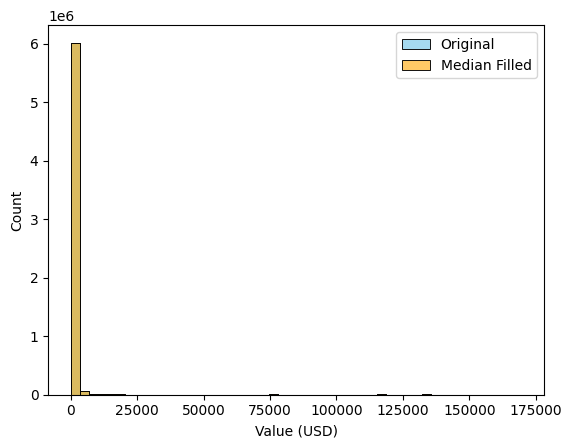

Original mean: 789.3074919446872
Median-filled mean: 788.7883049700292


In [ ]:
sns.histplot(df['Value (USD)'], bins=50, color='skyblue', label='Original')
sns.histplot(df_filled_median['Value (USD)'], bins=50, color='orange', label='Median Filled', alpha=0.6)
plt.legend()
plt.show()

# Simple analysis: mean value
print("Original mean:", df['Value (USD)'].mean())
print("Median-filled mean:", df_filled_median['Value (USD)'].mean())


# Filling numeric columns with mean

In [12]:
df_mean = df.copy()
for col in numeric_cols:
    df_mean[col].fillna(df[col].mean(), inplace=True)


/tmp/ipython-input-3270334859.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_mean[col].fillna(df[col].mean(), inplace=True)


**Winsorization**

In [14]:
df_median = df.copy()
for col in numeric_cols:
    df_median[col].fillna(df[col].median(), inplace=True)


/tmp/ipython-input-1811292563.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_median[col].fillna(df[col].median(), inplace=True)


In [15]:
df_winsor = df_median.copy()
for col in numeric_cols:
    lower = df_winsor[col].quantile(0.01)
    upper = df_winsor[col].quantile(0.99)
    df_winsor[col] = df_winsor[col].clip(lower, upper)


**влияние на распределение и простой анализ**

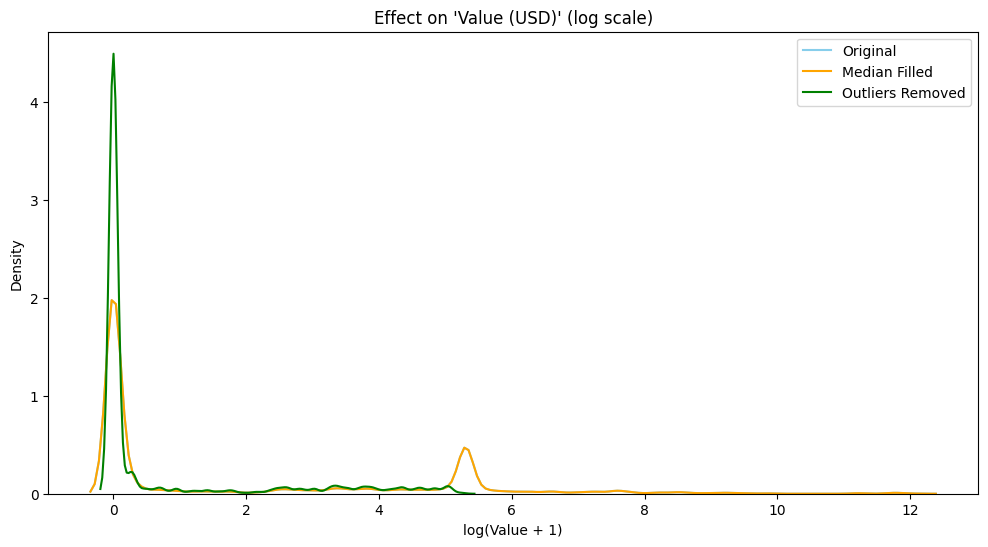

In [17]:
plt.figure(figsize=(12,6))
sns.kdeplot(np.log1p(df['Value (USD)']), label='Original', color='skyblue')
sns.kdeplot(np.log1p(df_median['Value (USD)']), label='Median Filled', color='orange')
sns.kdeplot(np.log1p(df_no_outliers['Value (USD)']), label='Outliers Removed', color='green')
plt.title("Effect on 'Value (USD)' (log scale)")
plt.xlabel("log(Value + 1)")
plt.legend()
plt.show()


# Effective Method

Median preserves the central tendency without being affected by extreme transactions."Unknown" avoids dropping rare wallets or categories.Outlier treatment stabilizes distributions for ML models and analysis.Since we need to analyze rare and risky score it is certainly of use to keep even the outliers withing the dataset